In [152]:
import numpy as np
import matplotlib.pyplot as plt

from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, SourceCatalog
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.detection import DAOStarFinder

from astropy.stats import sigma_clipped_stats #to characterize the background
from astropy.visualization import SqrtStretch #for visualization of the fits files
from astropy.visualization.mpl_normalize import ImageNormalize #for visualization of the fits files
from astropy.io import fits

In [327]:
def get_data(file_list):
    flats = get_flats("Orange")[250:350, 650:950]
    frames = []
    for img in file_list:
        frames.append(img - 153.79 / flats)

    master = np.median(np.stack(frames, axis=0), axis = 0)

    return master[250:350, 650:950]

In [218]:
image_files_t = ["water_tribe/HD 175544/Halpha/"+str(n)+".fit" for n in range(116, 119)]
image_concat_t = np.array([fits.open(f)[0].data for f in image_files_t])
data_t = get_data(image_concat_t)

image_files_tred = ["water_tribe/HD 175544/R/0"+str(n)+".fit" for n in range(84, 94)]
image_concat_tred = np.array([fits.open(f)[0].data for f in image_files_tred])
data_tred = get_data(image_concat_tred)

In [230]:
print([fits.open(f)[0].header['EXPTIME'] for f in image_files_t])

[10.0, 20.0, 30.0]


In [312]:
def get_flats(types):
    if types == "Blue":
        r = range(60, 65)
    elif types == "Green":
        r = range(71, 76)
    elif types == "Orange":
        r = range(66, 71)
    l = ["../Lab 2/M11_2025_SEP_18/CCD Image " + str(n) + ".fit" for n in r]
    flats = []
    for file in l:
        img = fits.getdata(file)
        flats.append(img / np.median(img))

    master_flat = np.median(np.stack(flats, axis=0), axis=0)

    return master_flat

In [313]:
get_flats("Orange")[250:350, 650:950]

array([[0.84787736, 0.78436019, 0.77014218, ..., 0.84241706, 0.75117925,
        0.75592417],
       [0.84787736, 0.78327444, 0.77004717, ..., 0.83510012, 0.75235849,
        0.75029446],
       [0.85041225, 0.77830189, 0.76658768, ..., 0.84687868, 0.75353774,
        0.75825472],
       ...,
       [0.86219081, 0.79363208, 0.73933649, ..., 0.66981132, 0.69266589,
        0.73498233],
       [0.85630153, 0.79620853, 0.7322468 , ..., 0.67020024, 0.68433451,
        0.73696682],
       [0.86808009, 0.79146919, 0.74174528, ..., 0.66943128, 0.68551237,
        0.72991851]], shape=(100, 300))

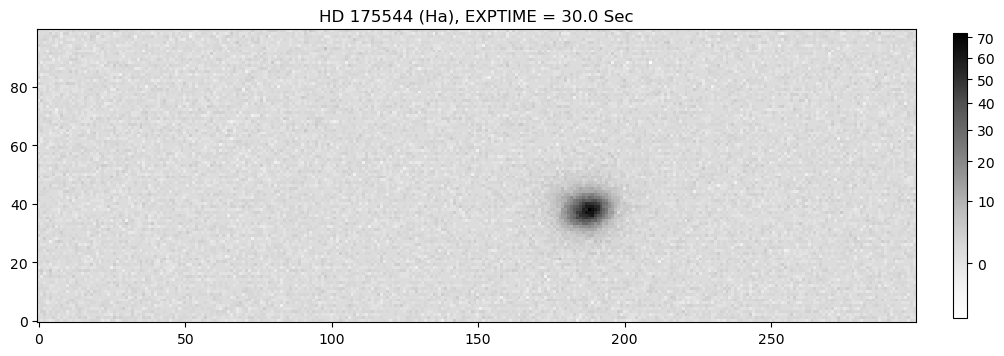

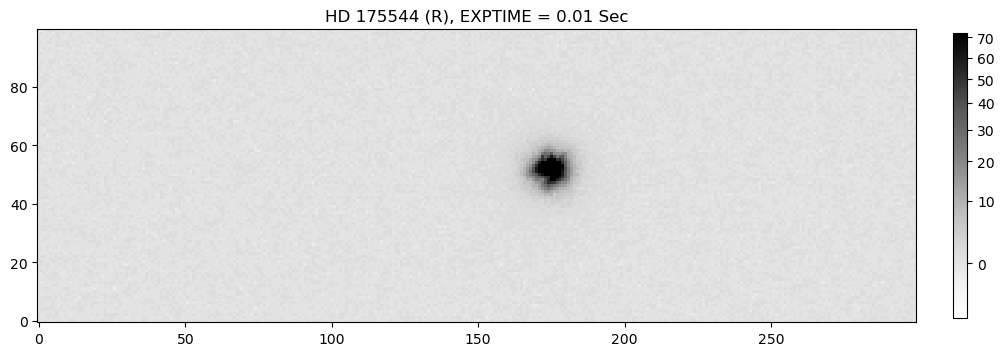

In [328]:
master_bias_average = 153.79 #average of master (average) bias frame

hdu = fits.open("water_tribe/HD 175544/Halpha/118.fit")
hdr = hdu[0].header #to get exposure time
data = hdu[0].data[250:350, 650:950] #full image is 512X2048
data = data - master_bias_average

hdured = fits.open("water_tribe/HD 175544/R/091.fit")
hdred = hdured[0].header #to get exposure time
datared = hdured[0].data[250:350, 650:950] #full image is 512X2048
datared = datared - master_bias_average
datared = datared / get_flats("Orange")[250:350, 650:950]
datared = data_tred

plt.figure(figsize=(12, 12))
norm = ImageNormalize(stretch=SqrtStretch()) #for imshow display
plt.imshow(data, cmap='Greys', origin='lower', interpolation='nearest', norm=norm) #vmax = 5 required to see the stars.
plt.title("HD 175544 (Ha), EXPTIME = " + str(hdr['EXPTIME']) + " Sec")
im_ratio = data.shape[0]/data.shape[1] 
plt.colorbar(fraction=0.046*im_ratio, pad=0.04) #to scale colorbar to size of frame
plt.savefig("Figures/HD175544_Ha_plain")

plt.figure(figsize=(12, 12))
plt.imshow(datared, cmap='Greys', origin='lower', interpolation='nearest', norm=norm) #vmax = 5 required to see the stars.
plt.title("HD 175544 (R), EXPTIME = " + str(hdred['EXPTIME']) + " Sec")
im_ratio = data.shape[0]/data.shape[1] 
plt.colorbar(fraction=0.046*im_ratio, pad=0.04) #to scale colorbar to size of frame
plt.savefig("Figures/HD175544_Red_plain")

hdu.close()
hdured.close()

In [329]:
def calculate_segments(data, t):
    bkg_estimator = MedianBackground() # background estimation
    bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                    bkg_estimator=bkg_estimator)
    data -= bkg.background  # subtract the background
    
    threshold = 5.0 * bkg.background_rms
    
    #convolve with kernel to increase S/N 
    kernel = make_2dgaussian_kernel(3.0, size=5)  # FWHM = 3.0
    convolved_data = convolve(data, kernel)
    
    segment_map = detect_sources(convolved_data, threshold, npixels=10) #10 connected pixels greater than threshold
    print(segment_map)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(segment_map, origin='lower', cmap=segment_map.cmap,
               interpolation='nearest')
    plt.title('Segmentation Image')
    plt.savefig("Figures/HD175544"+t+"segmented")
    return segment_map, convolved_data

In [330]:
def get_cat(data, segment_map, convolve_data, t):
    cat = SourceCatalog(data, segment_map, convolved_data=convolved_data) #photometry
    tbl = cat.to_table()
    tbl['xcentroid'].info.format = '.2f'  # optional format
    tbl['ycentroid'].info.format = '.2f'
    tbl['kron_flux'].info.format = '.2f'
    print(t, tbl)
    return tbl

<photutils.segmentation.core.SegmentationImage>
shape: (100, 300)
nlabels: 1
labels: [1]
Halpha label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    187.37     37.76 ...             nan   7371.98          nan
<photutils.segmentation.core.SegmentationImage>
shape: (100, 300)
nlabels: 1
labels: [1]
Red label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    178.52     45.69 ...             nan  11048.73          nan


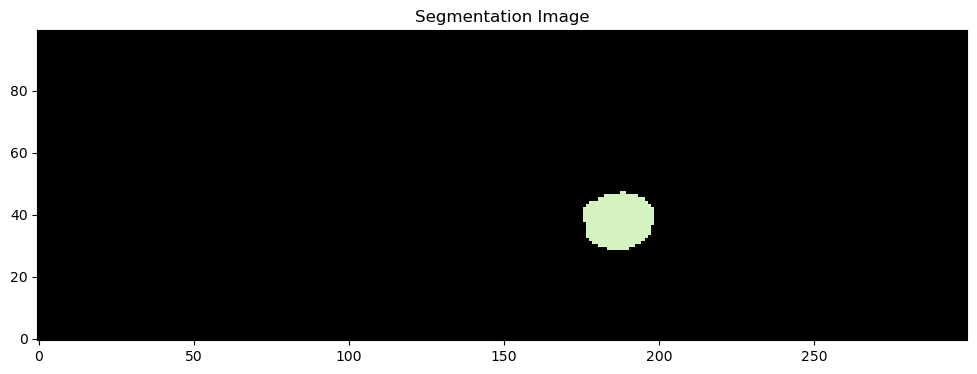

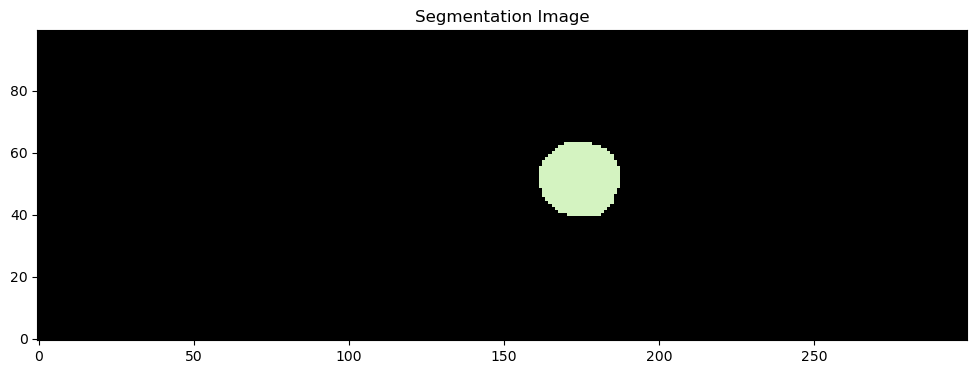

In [331]:
segment_map, convolved_data = calculate_segments(data, "Ha")
tbl = get_cat(data, segment_map, convolved_data, "Halpha")

segment_map_red, convolved_data_red = calculate_segments(datared, "Red")
tbl_red = get_cat(datared, segment_map_red, convolved_data_red, "Red")

In [325]:
tbl['kron_flux'] / hdr['EXPTIME']

245.73


In [332]:
tbl_red['kron_flux'] / hdred['EXPTIME'] 

1104873.33


In [339]:
float(tbl['kron_flux'] / hdr['EXPTIME']) / float(tbl_red['kron_flux'] / hdred['EXPTIME'] ) * 3.47 * 10 **-23 * 6.21 * 10**13

/var/folders/kh/46fkh84d3699xzz7ybmcqqp00000gn/T/ipykernel_7154/3902078672.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(tbl['kron_flux'] / hdr['EXPTIME']) / float(tbl_red['kron_flux'] / hdred['EXPTIME'] ) * 3.47 * 10 **-23 * 6.21 * 10**13


4.792603650156814e-13

In [340]:
float(tbl['kron_flux'] / hdr['EXPTIME']) / float(tbl_red['kron_flux'] / hdred['EXPTIME'] )

/var/folders/kh/46fkh84d3699xzz7ybmcqqp00000gn/T/ipykernel_7154/2808258078.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(tbl['kron_flux'] / hdr['EXPTIME']) / float(tbl_red['kron_flux'] / hdred['EXPTIME'] )


0.00022240801766031427

In [239]:
f_R = 3.47 #Jy

In [240]:
f_Ha = (245.73 / 1104873.33) * f_R

In [182]:
f_Ha # Jy

0.0006011369700319453

In [241]:
f_Ha

0.0007717473821184551

In [130]:
def get_master_bias(file_list):
    bias_frames = []
    for img in file_list:
        bias_frames.append(img)

    master_bias = np.median(np.stack(bias_frames, axis=0), axis=0)

    return np.median(master_bias)

In [133]:
image_files = ["M57/CCD Image " + str(n) + ".fit" for n in [206, 208, 211]]
image_concat = np.array([fits.getdata(f) for f in image_files])
master_bias = get_master_bias(image_concat)

In [134]:
master_bias

np.float64(98.0)

In [167]:
def get_data():

    l = ["M57/Ha-Filter-00" + str(n) + "-60s.fit" for n in range(1, 6)]
    hdus = []
    for image_file in l:
        img = fits.getdata(image_file)[100:400, 800:1200]
        hdus.append((img - master_bias))
    data = np.median(hdus, axis=0)

    return data

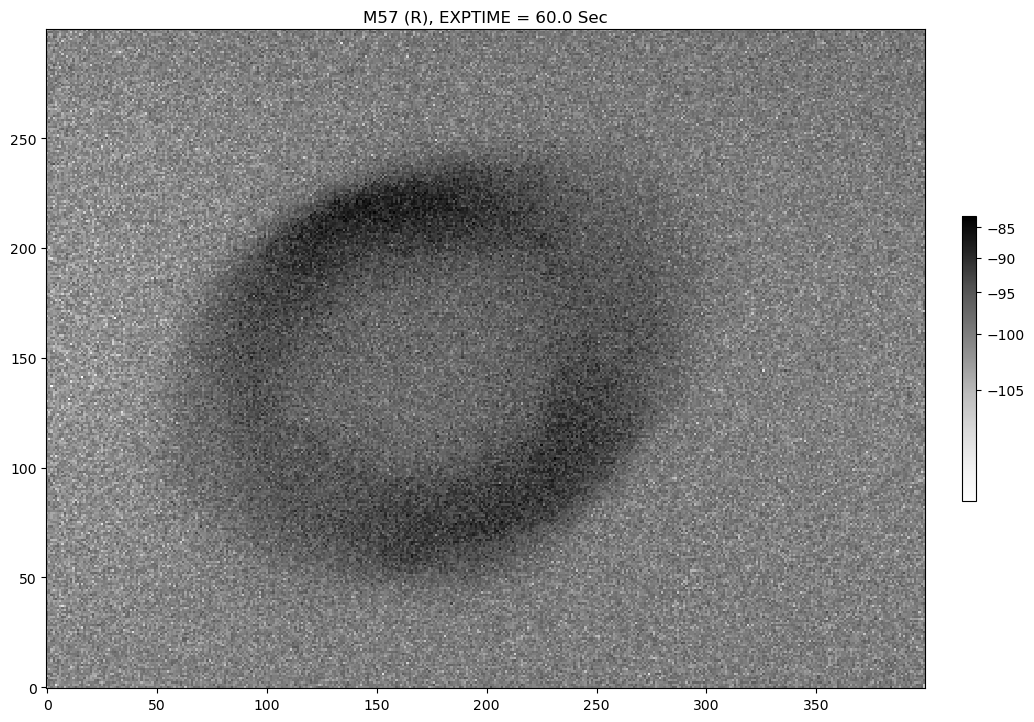

In [170]:
hdum57 = fits.open("M57/Ha-Filter-001-60s.fit")
hdm57 = hdum57[0].header #to get exposure time
#datam57 = hdum57[0].data[100:400, 750:1250]#full image is 512X2048
datam57 = get_data()
datam57 = datam57 - master_bias

plt.figure(figsize=(12, 12))
norm = ImageNormalize(stretch=SqrtStretch()) #for imshow display
plt.imshow(datam57, cmap='Greys', origin='lower', interpolation='nearest', norm=norm) #vmax = 5 required to see the stars.
plt.title("M57 (R), EXPTIME = " + str(hdm57['EXPTIME']) + " Sec")
im_ratio = data.shape[0]/data.shape[1] 
plt.colorbar(fraction=0.046*im_ratio, pad=0.04) #to scale colorbar to size of frame

mean: 0.0810550302945315 median: 0.008707118178143514 std: 2.1210382435298216


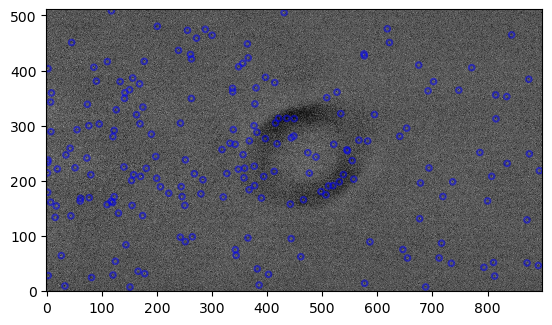

In [157]:
mean, median, std = sigma_clipped_stats(datam57, sigma=5.0)
print("mean: " + str(mean) + " median: " + str(median) + " std: " + str(std))
    # load the DAOStarFinder function. The FWHM tell it how to determine the radius of a star
    # the threshold helps determine when to ignore something and consider it not a star.

    # Give a high threshold, only brighter stars will be selected, a low threshold will circle nearly everything
threshold = 3 * std

    # this tells which size of PSF (size of star on image) that you want to circle. Give a high fwhm to circle larger PSF's
    # or in other words, larger stars. Give a small fwhm to circle smaller PSF's or 'smaller' stars.
fwhm = 3
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)

    # subtract the background from the imgage so the software doesn't get background light confused with stars
background_subracted_data = datam57 - median

mask[120:, 800:1000] = True   # first excluded box

sources = daofind(background_subracted_data, mask=mask)
circle_size = 5
    # So this just transposes the positions matrix so the data is in the right format for photutil
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
    # This is a photutil function which draws circles around targets
apertures = CircularAperture(positions, r=circle_size)
plt.imshow(datam57, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

In [158]:
mask = np.zeros_like(datam57, dtype=bool)
if sources is not None:
    for x, y in zip(sources['xcentroid'], sources['ycentroid']):
        yy, xx = np.ogrid[:datam57.shape[0], :datam57.shape[1]]
        r = np.sqrt((xx - x)**2 + (yy - y)**2)
        mask[r < 5*fwhm] = True

In [163]:
calculate_segments(datam57, mask)

None


AttributeError: 'NoneType' object has no attribute 'cmap'

<Figure size 1200x1200 with 0 Axes>